# Phase 1: Static Line Formation

**Goal**: Train the NCA to grow from a seed into a stable line formation.

**Key Insight**: The seed has ~16 cells but the target has ~109. The NCA must GROW mass to fill the formation. We use **target mass matching** (not seed mass conservation).

**Success Criteria**:
- Formation loss < 0.005
- Final mass within 10% of target mass
- Stable formation maintained over 100+ steps

**Next Step**: Once Phase 1 is complete, proceed to `phase2_formation_transitions.ipynb`

In [40]:
# Setup
import subprocess
import sys
import os

REPO_URL = "https://github.com/JackHopkins/FormationHNCA.git"

if os.path.exists("/content"):
    REPO_DIR = "/content/FormationHNCA"
elif os.path.exists("/workspace"):
    REPO_DIR = "/workspace/FormationHNCA"
else:
    REPO_DIR = os.path.expanduser("~/FormationHNCA")

if os.path.exists(REPO_DIR):
    print(f"Pulling latest changes in {REPO_DIR}...")
    result = subprocess.run(["git", "-C", REPO_DIR, "pull"], capture_output=True, text=True)
    print(result.stdout or "Already up to date.")
else:
    print(f"Cloning repository to {REPO_DIR}...")
    subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)

os.chdir(REPO_DIR)

print("Installing JAX with CUDA support...")
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "jax[cuda12]"], check=True)

print("Installing battle-nca package...")
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-e", "."], check=True)

src_path = os.path.join(REPO_DIR, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"\nWorking directory: {os.getcwd()}")
print("Setup complete!")

Pulling latest changes in /workspace/FormationHNCA...
Already up to date.

Installing JAX with CUDA support...
Installing battle-nca package...

Working directory: /workspace/FormationHNCA
Setup complete!


In [41]:
import jax
import gc

gc.collect()
jax.clear_caches()

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

if jax.devices()[0].platform == 'gpu':
    print("GPU acceleration enabled!")
else:
    print("WARNING: Running on CPU.")

JAX version: 0.8.2
JAX devices: [CudaDevice(id=0)]
GPU acceleration enabled!


In [42]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import time
import pickle
from pathlib import Path

from battle_nca.core import NCA, perceive
from battle_nca.core.nca import create_seed
from battle_nca.hierarchy import ChildNCA, ParentNCA, HierarchicalNCA
from battle_nca.hierarchy.child_nca import create_army_seed, CHILD_CHANNELS
from battle_nca.combat import FormationTargets, create_formation_target, rotate_formation
from battle_nca.combat.formations import FormationTypes
from battle_nca.training import NCAPool, Trainer, TrainingConfig
from battle_nca.training.optimizers import create_optimizer, normalize_gradients

print("All imports successful!")

All imports successful!


## Configuration

In [43]:
GRID_SIZE = 64
NUM_CHANNELS = 24

# RESET: Set to True to retrain from scratch
RESET = True

config = TrainingConfig(
    batch_size=32,
    pool_size=1024,
    min_steps=128,
    max_steps=192,
    learning_rate=2e-3,
    gradient_clip=1.0,
    damage_samples=3,
    damage_start_epoch=500,
    log_interval=10,
    checkpoint_interval=500
)

PHASE1_EPOCHS = 1500  # More epochs for growing task
SEED = 42

CHECKPOINT_PATH = Path('checkpoints/phase1_line.pkl')
CHECKPOINT_PATH.parent.mkdir(exist_ok=True)

print(f"Phase 1: Line Formation Training")
print(f"Steps per iteration: {config.min_steps}-{config.max_steps}")
print(f"Max epochs: {PHASE1_EPOCHS}")

Phase 1: Line Formation Training
Steps per iteration: 128-192
Max epochs: 1500


## Create Model and Initialize

In [44]:
child_nca = ChildNCA(
    num_channels=NUM_CHANNELS,
    hidden_dim=128,
    fire_rate=0.5,
    use_circular_padding=True
)

seed = create_army_seed(
    height=GRID_SIZE,
    width=GRID_SIZE,
    team_color=(1.0, 0.0, 0.0),
    unit_type=0,
    formation_id=0,
    spawn_region=(GRID_SIZE//2 - 2, GRID_SIZE//2 + 2, GRID_SIZE//2 - 2, GRID_SIZE//2 + 2)
)

print(f"Seed shape: {seed.shape}")
print(f"Seed mass: {float(jnp.sum(seed[..., 3])):.1f}")

Seed shape: (64, 64, 24)
Seed mass: 16.0


In [45]:
key = jax.random.PRNGKey(SEED)
key, init_key = jax.random.split(key)

def count_params(params):
    return sum(p.size for p in jax.tree_util.tree_leaves(params))

loaded_checkpoint = None

if not RESET and CHECKPOINT_PATH.exists():
    print(f"Loading checkpoint from {CHECKPOINT_PATH}...")
    with open(CHECKPOINT_PATH, 'rb') as f:
        loaded_checkpoint = pickle.load(f)
    params = loaded_checkpoint['params']
    print(f"  Loaded model with {count_params(params):,} parameters")
    
    if 'metrics' in loaded_checkpoint:
        epochs_done = len(loaded_checkpoint['metrics'].get('losses', []))
        best = loaded_checkpoint['metrics'].get('best_loss', float('inf'))
        print(f"  Previous epochs: {epochs_done}, Best loss: {best:.6f}")
else:
    print("Initializing fresh model...")
    dummy_signal = jnp.zeros((GRID_SIZE, GRID_SIZE, 2))
    variables = child_nca.init(init_key, seed, jax.random.PRNGKey(0), parent_signal=dummy_signal)
    params = variables['params']

print(f"Total parameters: {count_params(params):,}")

Initializing fresh model...
Total parameters: 36,466


## Target Formation: Line

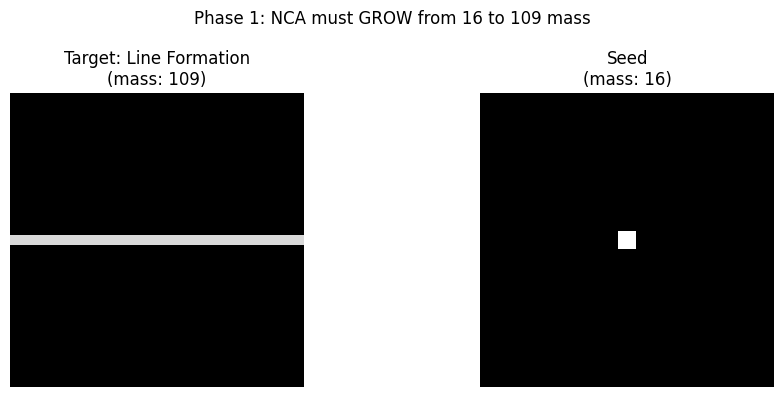


Seed mass: 16
Target mass: 109
Growth required: 6.8x


In [46]:
target = FormationTargets.line(GRID_SIZE, GRID_SIZE)
TARGET_MASS = float(jnp.sum(target[..., 3]))
SEED_MASS = float(jnp.sum(seed[..., 3]))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(target[..., 3], cmap='gray', vmin=0, vmax=1)
axes[0].set_title(f'Target: Line Formation\n(mass: {TARGET_MASS:.0f})')
axes[0].axis('off')

axes[1].imshow(seed[..., 3], cmap='gray', vmin=0, vmax=1)
axes[1].set_title(f'Seed\n(mass: {SEED_MASS:.0f})')
axes[1].axis('off')

plt.suptitle(f'Phase 1: NCA must GROW from {SEED_MASS:.0f} to {TARGET_MASS:.0f} mass', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nSeed mass: {SEED_MASS:.0f}")
print(f"Target mass: {TARGET_MASS:.0f}")
print(f"Growth required: {TARGET_MASS/SEED_MASS:.1f}x")

## Training Setup

**Key change**: For Phase 1, we match **target mass** not initial mass. The NCA needs to grow, not just redistribute.

In [47]:
optimizer = create_optimizer(
    learning_rate=config.learning_rate,
    gradient_clip=config.gradient_clip
)

state = train_state.TrainState.create(
    apply_fn=child_nca.apply,
    params=params,
    tx=optimizer
)

pool = NCAPool(seed, config.pool_size)

print(f"Pool size: {config.pool_size}")
print(f"Batch size: {config.batch_size}")

Pool size: 1024
Batch size: 32


In [ ]:
# Training step - Phase 1 uses TARGET mass matching (not seed mass conservation)
# OPTIMIZED: 
# 1. Vectorized checkpoint computation
# 2. Fixed num_steps to avoid recompilation
# 3. Pre-computed formation signal

NUM_CHECKPOINTS = 4
MASS_MATCHING_WEIGHT = 0.3

# FIX: Use fixed step count to avoid JIT recompilation for each unique num_steps
FIXED_NUM_STEPS = 160  # Middle of 128-192 range

# FIX: Pre-compute formation signal ONCE (it's constant for Phase 1)
FORMATION_SIGNAL = jnp.zeros((config.batch_size, GRID_SIZE, GRID_SIZE, 2))
# formation_idx=0, angle=0 -> formation_val = -1, angle_val = -1
FORMATION_SIGNAL = FORMATION_SIGNAL.at[..., 0].set(-1.0)  # Line formation
FORMATION_SIGNAL = FORMATION_SIGNAL.at[..., 1].set(-1.0)  # 0 angle

@jax.jit
def train_step(state, batch, target, key, formation_signal):
    """Training step with target mass matching (for growth phases).
    
    OPTIMIZED:
    - Fixed num_steps to avoid recompilation
    - Vectorized checkpoint computation
    - No Python loops inside JIT
    """
    num_steps = FIXED_NUM_STEPS
    
    def loss_fn(params):
        keys = jax.random.split(key, num_steps)
        target_mass = jnp.sum(target[..., 3])
        
        checkpoint_interval = num_steps // NUM_CHECKPOINTS
        
        def step(carry, inputs):
            step_idx, subkey = inputs
            state_in = carry.at[..., CHILD_CHANNELS.PARENT_SIGNAL_START:CHILD_CHANNELS.PARENT_SIGNAL_END].set(
                formation_signal[..., :2]
            )
            new_state = child_nca.apply(
                {'params': params}, state_in, subkey, parent_signal=formation_signal
            )
            return new_state, new_state
        
        step_inputs = (jnp.arange(num_steps), keys)
        final, all_states = jax.lax.scan(step, batch, step_inputs)
        # all_states shape: (num_steps, B, H, W, C)
        
        # === VECTORIZED checkpoint extraction ===
        checkpoint_indices = jnp.array([
            checkpoint_interval - 1,
            2 * checkpoint_interval - 1,
            3 * checkpoint_interval - 1,
            4 * checkpoint_interval - 1
        ])
        checkpoint_indices = jnp.minimum(checkpoint_indices, num_steps - 1)
        
        # Extract checkpoint states: (4, B, H, W, C)
        checkpoint_states = all_states[checkpoint_indices]
        
        # === VECTORIZED formation loss ===
        checkpoint_errors = (checkpoint_states[..., :4] - target) ** 2
        checkpoint_mses = jnp.mean(checkpoint_errors, axis=(1, 2, 3, 4))  # (4,)
        checkpoint_weights = jnp.array([0.1, 0.2, 0.3, 0.4])
        formation_loss = jnp.sum(checkpoint_weights * checkpoint_mses)
        
        # === VECTORIZED mass matching loss ===
        checkpoint_masses = jnp.sum(checkpoint_states[..., 3], axis=(2, 3))  # (4, B)
        relative_errors = jnp.abs(checkpoint_masses - target_mass) / (target_mass + 1e-6)
        mass_matching_loss = jnp.mean(relative_errors)
        
        total_loss = formation_loss + MASS_MATCHING_WEIGHT * mass_matching_loss
        return total_loss, (final, formation_loss, mass_matching_loss)
    
    (loss, (outputs, form_loss, mass_loss)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    grads = normalize_gradients(grads)
    state = state.apply_gradients(grads=grads)
    return state, loss, outputs, form_loss, mass_loss


print("Training step ready (OPTIMIZED).")
print(f"  - Fixed steps: {FIXED_NUM_STEPS} (no recompilation)")
print(f"  - Pre-computed formation signal")
print(f"  - Vectorized checkpoint computation")
print(f"  - Mass matching weight: {MASS_MATCHING_WEIGHT}")

## Phase 1 Training

In [ ]:
print("="*60)
print("PHASE 1: Grow Seed into Line Formation")
print("="*60)
print(f"Target: Grow from {SEED_MASS:.0f} -> {TARGET_MASS:.0f} mass")
print(f"Fixed steps per iteration: {FIXED_NUM_STEPS}")
print()

PATIENCE = 300
MIN_DELTA = 1e-6

losses = []
form_losses = []
mass_losses = []
times = []
best_loss = float('inf')
best_params = None
epochs_without_improvement = 0

# Time the first epoch (includes JIT compilation)
print("Compiling JIT (first epoch will be slow)...")

for epoch in range(PHASE1_EPOCHS):
    start_time = time.time()
    key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
    
    indices, batch = pool.sample(config.batch_size, subkey1)
    
    if epoch > config.damage_start_epoch:
        batch = pool.apply_damage(batch, config.damage_samples, subkey2)
    
    # Use pre-computed FORMATION_SIGNAL instead of calling create_formation_signal
    state, loss, outputs, form_loss, mass_loss = train_step(
        state, batch, target, subkey3, FORMATION_SIGNAL
    )
    
    loss_val = float(loss)
    form_loss_val = float(form_loss)
    mass_loss_val = float(mass_loss)
    
    if np.isnan(loss_val) or np.isinf(loss_val):
        print(f"\nEarly stopping at epoch {epoch}: loss is {loss_val}")
        if best_params is not None:
            state = state.replace(params=best_params)
        break
    
    if loss_val < best_loss - MIN_DELTA:
        best_loss = loss_val
        best_params = state.params
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch}: no improvement for {PATIENCE} epochs")
        state = state.replace(params=best_params)
        break
    
    per_sample_losses = jnp.mean((outputs[..., :4] - target) ** 2, axis=(1, 2, 3))
    pool.update(indices, outputs, per_sample_losses)
    
    elapsed = time.time() - start_time
    losses.append(loss_val)
    form_losses.append(form_loss_val)
    mass_losses.append(mass_loss_val)
    times.append(elapsed)
    
    if epoch % config.log_interval == 0:
        current_mass = float(jnp.mean(jnp.sum(outputs[..., 3], axis=(1, 2))))
        mass_ratio = current_mass / TARGET_MASS
        print(f"Epoch {epoch:4d}: loss={loss_val:.6f} (form:{form_loss_val:.6f}, mass:{mass_loss_val:.4f}), " +
              f"mass={current_mass:.0f}/{TARGET_MASS:.0f} ({mass_ratio:.0%}), {elapsed:.2f}s")

print(f"\nPhase 1 complete. Best loss: {best_loss:.6f}")
if len(times) > 1:
    print(f"Average time per epoch (after JIT): {np.mean(times[1:]):.3f}s")

## Training Curves

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

window = 50

# Total loss
axes[0, 0].plot(losses, alpha=0.5)
if len(losses) > window:
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    axes[0, 0].plot(range(window-1, len(losses)), smoothed, 'r-', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Total Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_yscale('log')

# Formation loss
axes[0, 1].plot(form_losses, alpha=0.5, color='blue')
if len(form_losses) > window:
    smoothed = np.convolve(form_losses, np.ones(window)/window, mode='valid')
    axes[0, 1].plot(range(window-1, len(form_losses)), smoothed, 'b-', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Formation Loss')
axes[0, 1].set_title('Formation Loss (shape matching)')
axes[0, 1].set_yscale('log')

# Mass matching loss
axes[1, 0].plot(mass_losses, alpha=0.5, color='green')
if len(mass_losses) > window:
    smoothed = np.convolve(mass_losses, np.ones(window)/window, mode='valid')
    axes[1, 0].plot(range(window-1, len(mass_losses)), smoothed, 'g-', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Mass Matching Error')
axes[1, 0].set_title('Mass Matching Loss (vs target)')

# Time per epoch
axes[1, 1].plot(times, alpha=0.5, color='orange')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Time (s)')
axes[1, 1].set_title('Time per Epoch')

plt.tight_layout()
plt.show()

## Save Checkpoint

In [ ]:
checkpoint = {
    'params': state.params,
    'config': {
        'grid_size': GRID_SIZE,
        'num_channels': NUM_CHANNELS,
        'hidden_dim': 128,
        'goal_conditioned': True,
        'phase': 1,
        'target_mass': TARGET_MASS,
    },
    'metrics': {
        'losses': losses,
        'form_losses': form_losses,
        'mass_losses': mass_losses,
        'best_loss': best_loss,
    }
}

with open(CHECKPOINT_PATH, 'wb') as f:
    pickle.dump(checkpoint, f)

print(f"Checkpoint saved to {CHECKPOINT_PATH}")
print(f"Best loss: {best_loss:.6f}")

---

# Evaluation & Visualization

In [ ]:
def run_model(initial_state, params, key, num_steps=150):
    """Run the NCA and return trajectory."""
    signal = create_formation_signal(1, GRID_SIZE, GRID_SIZE, 0, 0.0)
    signal_single = signal[0]
    
    trajectory = [initial_state]
    state_curr = initial_state
    
    for i in range(num_steps):
        key, subkey = jax.random.split(key)
        state_curr = state_curr.at[..., CHILD_CHANNELS.PARENT_SIGNAL_START:CHILD_CHANNELS.PARENT_SIGNAL_END].set(
            signal_single[..., :2]
        )
        state_curr = child_nca.apply(
            {'params': params}, state_curr, subkey, parent_signal=signal_single
        )
        trajectory.append(state_curr)
    
    return trajectory

key, eval_key = jax.random.split(key)
trajectory = run_model(seed, state.params, eval_key, num_steps=150)
print(f"Generated trajectory with {len(trajectory)} frames")

In [ ]:
# Visualize evolution
timesteps = [0, 25, 50, 75, 100, 125, 150]
fig, axes = plt.subplots(2, len(timesteps), figsize=(3*len(timesteps), 6))

for i, t in enumerate(timesteps):
    if t < len(trajectory):
        frame = trajectory[t]
        mass = float(jnp.sum(frame[..., 3]))
        
        axes[0, i].imshow(frame[..., 3], cmap='gray', vmin=0, vmax=1)
        axes[0, i].set_title(f't={t}\nmass={mass:.0f}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(np.clip(frame[..., :4], 0, 1))
        axes[1, i].axis('off')

axes[0, 0].set_ylabel('Alpha', fontsize=12)
axes[1, 0].set_ylabel('RGBA', fontsize=12)

plt.suptitle(f'NCA Growth: {SEED_MASS:.0f} -> {TARGET_MASS:.0f} mass target', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Compare final state to target
final_state = trajectory[-1]
final_mass = float(jnp.sum(final_state[..., 3]))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(target[..., 3], cmap='gray', vmin=0, vmax=1)
axes[0].set_title(f'Target\n(mass: {TARGET_MASS:.0f})')
axes[0].axis('off')

axes[1].imshow(final_state[..., 3], cmap='gray', vmin=0, vmax=1)
axes[1].set_title(f'Final State\n(mass: {final_mass:.0f})')
axes[1].axis('off')

diff = np.abs(np.array(target[..., 3]) - np.array(final_state[..., 3]))
mse = np.mean(diff**2)
axes[2].imshow(diff, cmap='hot', vmin=0, vmax=1)
axes[2].set_title(f'Difference\n(MSE: {mse:.6f})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Mass growth analysis
masses = [float(jnp.sum(t[..., 3])) for t in trajectory]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(masses, 'b-', linewidth=2)
axes[0].axhline(y=SEED_MASS, color='gray', linestyle='--', label=f'Seed: {SEED_MASS:.0f}')
axes[0].axhline(y=TARGET_MASS, color='r', linestyle='--', label=f'Target: {TARGET_MASS:.0f}')
axes[0].fill_between(range(len(masses)), TARGET_MASS*0.9, TARGET_MASS*1.1, alpha=0.2, color='green', label='10% of target')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Total Mass')
axes[0].set_title('Mass Growth Over Time')
axes[0].legend()

# Mass as % of target
mass_pct = [m / TARGET_MASS * 100 for m in masses]
axes[1].plot(mass_pct, 'b-', linewidth=2)
axes[1].axhline(y=100, color='r', linestyle='--', label='Target (100%)')
axes[1].axhline(y=90, color='g', linestyle=':', alpha=0.5)
axes[1].axhline(y=110, color='g', linestyle=':', alpha=0.5)
axes[1].fill_between(range(len(mass_pct)), 90, 110, alpha=0.2, color='green', label='Within 10%')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Mass (% of target)')
axes[1].set_title('Mass as Percentage of Target')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Seed mass: {SEED_MASS:.0f}")
print(f"Final mass: {masses[-1]:.0f}")
print(f"Target mass: {TARGET_MASS:.0f}")
print(f"Final/Target ratio: {masses[-1]/TARGET_MASS:.1%}")

In [ ]:
# Stability test
key, stability_key = jax.random.split(key)
long_trajectory = run_model(seed, state.params, stability_key, num_steps=300)

check_points = [0, 50, 100, 150, 200, 250, 300]
fig, axes = plt.subplots(1, len(check_points), figsize=(3*len(check_points), 3))

for i, t in enumerate(check_points):
    if t < len(long_trajectory):
        mass = float(jnp.sum(long_trajectory[t][..., 3]))
        axes[i].imshow(long_trajectory[t][..., 3], cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f't={t}\n({mass:.0f})')
        axes[i].axis('off')

plt.suptitle('Stability Test: Is formation maintained over 300 steps?', fontsize=12)
plt.tight_layout()
plt.show()

## Success Criteria Check

In [ ]:
final_form_loss = np.mean((np.array(final_state[..., :4]) - np.array(target)) ** 2)
final_mass = float(jnp.sum(final_state[..., 3]))
mass_accuracy = final_mass / TARGET_MASS  # 1.0 = perfect

# Check stability at t=300
late_mass = float(jnp.sum(long_trajectory[-1][..., 3]))
stability = late_mass / final_mass  # Should be ~1.0 if stable

print("=" * 60)
print("PHASE 1 SUCCESS CRITERIA")
print("=" * 60)

criteria = [
    ("Formation MSE < 0.01", final_form_loss, 0.01, final_form_loss < 0.01),
    ("Mass within 10% of target", mass_accuracy, "0.9-1.1", 0.9 <= mass_accuracy <= 1.1),
    ("Stable at t=300 (within 10%)", stability, "0.9-1.1", 0.9 <= stability <= 1.1),
]

all_passed = True
for name, value, threshold, passed in criteria:
    status = "PASS" if passed else "FAIL"
    if isinstance(value, float):
        print(f"{name}: {value:.4f} (threshold: {threshold}) [{status}]")
    else:
        print(f"{name}: {value} (threshold: {threshold}) [{status}]")
    if not passed:
        all_passed = False

print("=" * 60)
print(f"\nSummary:")
print(f"  Seed mass: {SEED_MASS:.0f}")
print(f"  Target mass: {TARGET_MASS:.0f}")
print(f"  Final mass: {final_mass:.0f} ({mass_accuracy:.0%} of target)")
print(f"  Formation MSE: {final_form_loss:.6f}")

print("\n" + "=" * 60)
if all_passed:
    print("ALL CRITERIA PASSED - Ready for Phase 2!")
    print("\nNext: Run phase2_formation_transitions.ipynb")
else:
    print("SOME CRITERIA FAILED - Consider more training")
    print("\nTry: Set RESET=False and run training again")